In [1]:
import math
import numpy as np
import torch
from pathlib import Path
import sys
import time
sys.path.append("..")

#import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

#from falkon.kernels import GaussianKernel
#from falkon import FalkonOptions
#from falkon.center_selection import UniformSelector, FixedSelector
#from nyskoop.data.Duff import Duffing
#from experiment_helpers import *

import scipy.io
import os
#from falkon.utils.tensor_helpers import create_same_stride
#from nyskoop.estimators import KoopmanNystromKrr
#from nyskoop.estimators.estimator_utils import (
#    fetch_topr_eigensystem, pseudo_inverse, EIGENVALUE_EPS, id_regularize, Eigendecomposition
#)
from timeit import default_timer as timer

import pickle

In [2]:
def GaussianKernel(mu):

    def my_kernel(X,Y):
        """
        Compute the Gaussian kernel matrix between two sets of data points.

        Parameters:
         - X: ndarray, shape (n_features, n_samples_X)
          The first set of data points.
         - Y: ndarray, shape (n_features, n_samples_Y)
          The second set of data points.
         - sigma: float, optional (default=1.0)
          The bandwidth of the Gaussian kernel.

        Returns:
        - K: ndarray, shape (n_samples_X, n_samples_Y)
           The Gaussian kernel matrix.
        """
        # Ensure X and Y are arrays
        #X, Y = np.asarray(X), np.asarray(Y)

        # Compute squared Euclidean distances
        dist_sq = torch.sum(X.t()**2, dim=1)[:, None] + torch.sum(Y.t()**2, dim=1) - 2 * torch.mm(X.t(), Y)

        # Compute the Gaussian kernel matrix
        return torch.exp(-dist_sq / mu)
    return my_kernel

def id_regularize(A,regul):
    return A+regul*torch.eye(A.size(dim=0))

In [3]:
data_folder = 'CylFlowdata'
def loadfile(name):
    c = scipy.io.loadmat(name)
    VP = c['VP']
    cylPos = c['cylPos'][0]
    time_ma = c['time'][0]
    VPshaped = VP.reshape(-1, 3, 45, 41)
    VPshaped = np.swapaxes(VPshaped, 2, 3) #swap x and y for easier plotting
    return  time_ma, VP.T, VPshaped, cylPos

matfiles = [f'{data_folder}/{n}' for n in os.listdir(data_folder) if n.endswith('mat')]
def num(s):
    s = list(s[len(f'{data_folder}/CylFlowFieldData'):].split('.')[0])
    s.insert(1,'.')
    return float(''.join(s))
matfiles = sorted(matfiles,key=num)
print(matfiles)


['CylFlowdata/CylFlowFieldData050.mat', 'CylFlowdata/CylFlowFieldData075.mat', 'CylFlowdata/CylFlowFieldData100.mat', 'CylFlowdata/CylFlowFieldData125.mat', 'CylFlowdata/CylFlowFieldData150.mat', 'CylFlowdata/CylFlowFieldData175.mat', 'CylFlowdata/CylFlowFieldData200.mat', 'CylFlowdata/CylFlowFieldData225.mat', 'CylFlowdata/CylFlowFieldData250.mat', 'CylFlowdata/CylFlowFieldData275.mat', 'CylFlowdata/CylFlowFieldData300.mat']


In [4]:

time_ma, _ , _, _= loadfile(matfiles[0])

In [5]:
def Gathering_traj_datasets(matfiles,test_ids):
    for i in range(len(test_ids)):
        _, VP_T , _, cylPos= loadfile(matfiles[test_ids[i]])
        U_traj=np.expand_dims(cylPos,0)
        if i==0:
            Trajtot_test=VP_T
            Trajtot_U_test=U_traj
        else:
            Trajtot_test=np.dstack((Trajtot_test,VP_T))
            Trajtot_U_test=np.dstack((Trajtot_U_test,U_traj))


    Nstep_test=Trajtot_test.shape[1]-1 #Amount of steps to be predicted 
    Ntraj_test=Trajtot_test.shape[2] #Amount of trajectories to be predicted
    N_D_test= Nstep_test*Ntraj_test
    return Trajtot_test, Trajtot_U_test,N_D_test,Nstep_test,Ntraj_test

In [6]:

#Gathering trajectory data
train_ids = [0, 2, 4, 6, 8, 10]
val_ids = [1, 5, 9]
test_ids = [3, 7]

Trajtot_test_OG, Trajtot_U_test_OG,N_D_test,Nstep_test,Ntraj_test=Gathering_traj_datasets(matfiles,test_ids)
Nx=Trajtot_test_OG.shape[0]
Nu=Trajtot_U_test_OG.shape[0]

Trajtot_valid_OG, Trajtot_U_valid_OG,N_D_valid,Nstep_valid,Ntraj_valid=Gathering_traj_datasets(matfiles,val_ids)

Nstep_valid=100
Trajtot_train_OG, Trajtot_U_train_OG,N_D,Nstep,Ntraj=Gathering_traj_datasets(matfiles,train_ids)


In [7]:
#Constants, normalizing the data and converting to torch tensor
def normalize_data(Trajtot_test,Trajtot_U_test,state_norm,input_norm):
    Trajtot_norm=Trajtot_test / state_norm
    Trajtot_U_norm=Trajtot_U_test / input_norm
    return Trajtot_norm,Trajtot_U_norm

def Converting_torch_tensor(Trajtot_test,Trajtot_U_test,dtype):
    Trajtot_test=torch.from_numpy(Trajtot_test).to(dtype=dtype)
    Trajtot_U_test=torch.from_numpy(Trajtot_U_test).to(dtype=dtype)
    return Trajtot_test, Trajtot_U_test

state_norm=3.5 #abs max seems to be 3.1358
input_norm= 0.0300 #abs max seems to be 0.0300

dt = 1/50 # Sampling time, sampling frequency is 50Hz
dtype = torch.float64
#opt = FalkonOptions(use_cpu=True)
font_int=14
#dir_name='/home/bdriessen/Documents/Notebooks/NystromKoopman/NystromKoopman-main/notebooks/Figs_Control_exp' #Location for saving the figures
filename_suffix= 'pdf'

Trajtot_test,Trajtot_U_test=normalize_data(Trajtot_test_OG,Trajtot_U_test_OG,state_norm,input_norm)
Trajtot_valid,Trajtot_U_valid=normalize_data(Trajtot_valid_OG,Trajtot_U_valid_OG,state_norm,input_norm)
Trajtot_train,Trajtot_U_train=normalize_data(Trajtot_train_OG,Trajtot_U_train_OG,state_norm,input_norm)

Trajtot_test,Trajtot_U_test=Converting_torch_tensor(Trajtot_test,Trajtot_U_test,dtype)
Trajtot_valid,Trajtot_U_valid=Converting_torch_tensor(Trajtot_valid,Trajtot_U_valid,dtype)
Trajtot_train,Trajtot_U_train=Converting_torch_tensor(Trajtot_train,Trajtot_U_train,dtype)

In [8]:
def Create_training_data(Trajtot_train,Trajtot_U_train,Ntraj):
    for i in range(Ntraj):
        if i==0:
            X_train=Trajtot_train[:,:-1,i] 
            Y_train=Trajtot_train[:,1:,i] 
            U_train=Trajtot_U_train[:,:-1,i]  
        else:
            X_train=torch.cat((X_train,Trajtot_train[:,:-1,i] ), dim=1)
            Y_train=torch.cat((Y_train,Trajtot_train[:,1:,i] ), dim=1)
            U_train=torch.cat((U_train,Trajtot_U_train[:,:-1,i] ), dim=1)
    return X_train,Y_train,U_train

#Important: the matrices below are not individually ordered on time, i.e. not all the columns corresponding to a timestep are grouped together
X_train,Y_train,U_train=Create_training_data(Trajtot_train,Trajtot_U_train,Ntraj) 

def Setup_validation_data(Nstep_valid,Ntraj_valid,Trajtot_valid):
    for i in range(Nstep_valid+1):
        for j in range(Ntraj_valid):
            x_valid=torch.unsqueeze(Trajtot_valid[:,i,j],1)
            if i==0 and j==0:
                Xtot_valid=x_valid
            elif i==Nstep_valid:
                Xtot_valid=torch.hstack((Xtot_valid,x_valid))
            else:
                Xtot_valid=torch.hstack((Xtot_valid,x_valid))

    return Xtot_valid[:,:Ntraj_valid],Xtot_valid[:,Ntraj_valid:],Xtot_valid

X0_valid, Ytot_valid, State_tot_valid=Setup_validation_data(Nstep_valid,Ntraj_valid,Trajtot_valid)


In [9]:
#def Generate_ind_points(X,Y,U,M):
    #X,Y Nx times N_D
#    cs = UniformSelector(random_gen=torch.randint(0, 1000, (1,)).item(), num_centers=M)
#    cs_x, cs_y, idx = cs.select(X.T.contiguous(), Y.T.contiguous())
#    cs_u = create_same_stride((M, U.shape[1]), other=U, dtype=U.dtype, device=U.device, pin_memory=False)
#    cs_u=torch.index_select(U.T, dim=0, index=idx)
#    return cs_x.T, cs_y.T, cs_u.T

def Generate_ind_points(X,Y,U,M):
    N=X.size(dim=1)
    if M>N:
        return print('error')
    #X,Y Nx times N_D
    #cs = UniformSelector(random_gen=torch.randint(0, 1000, (1,)).item(), num_centers=M)
    #cs_x, cs_y, idx = cs.select(X.T.contiguous(), Y.T.contiguous())
    #cs_u = create_same_stride((M, U.shape[1]), other=U, dtype=U.dtype, device=U.device, pin_memory=False)
    #cs_u=torch.index_select(U.T, dim=0, index=idx)
    idxs=torch.randperm(N)[:M]
    Xtilde=X[:,idxs]
    Ytilde=Y[:,idxs]
    Utilde=U[:,idxs]
    return Xtilde, Ytilde, Utilde


In [10]:
## Computing the predicition error
# Function to calculate the Root Mean Square Error per Traj
def Calculate_RMSE(Y_real,Y_pred):
    res=Y_real-Y_pred
    res_norm_squared=torch.pow(torch.norm(res,p=2,dim=0),2)
    RMSE_val=torch.sqrt(res_norm_squared.mean())
    return RMSE_val

def Calculate_RMSE_for_1_trajectory(Y_real,Y_pred):
    res=Y_real-Y_pred
    res_norm_squared=torch.pow(torch.norm(res,p=2,dim=0),2)
    RMSE_val=torch.sqrt(res_norm_squared)
    return RMSE_val

# Function to calculate the Mean Square Error per Traj
def Calculate_MSE(Y_real,Y_pred):
    res=Y_real-Y_pred
    res_norm_squared=torch.pow(torch.norm(res,p=2,dim=0),2)
    MSE_val=res_norm_squared.mean()
    return MSE_val

# Function to calculate the Root Mean Square Error over all Traj
def Calculate_RMSE_for_all_traj_in_ma(Y_real,Y_pred,Nx,Nstep,Ntraj):
    #Inputs Y_real nx times Ntraj*Nstep=ND
    res=Y_real-Y_pred
    res_3D=torch.reshape(res,(Nx,Nstep,Ntraj))
    res_2D_normsquared=torch.pow(torch.norm(res_3D,p=2,dim=0),2)
    RMSE_val=torch.sqrt(torch.mean(res_2D_normsquared,dim=0))
    return RMSE_val

def Calculate_RMSE_for_all_steps_in_ma(Y_real,Y_pred,Nx,Nstep,Ntraj):
    #Inputs Y_real nx times Ntraj*Nstep=ND
    res=Y_real-Y_pred
    res_3D=torch.reshape(res,(Nx,Nstep,Ntraj))
    res_2D_normsquared=torch.pow(torch.norm(res_3D,p=2,dim=0),2)
    RMSE_val=torch.sqrt(torch.mean(res_2D_normsquared,dim=1))
    return RMSE_val

In [11]:
### Estimating lifted system for Ny-KDMD and Ny-EDMD
## KDMD
def KDMD_create_kernel_ma(kernel_fnc,X_train,Y_train,U_train):
    U_diag=torch.diag(torch.squeeze(U_train))
    kx_nn = kernel_fnc(X_train, X_train)
    kxy_nn = kernel_fnc(X_train, Y_train)
    kxu_nn= kx_nn +  U_diag @ kx_nn @ U_diag
    return kxu_nn, kxy_nn, kx_nn, U_diag 


def KDMD_estimate_AB_final(penalty,kxu_nn, kxy_nn,U_diag):
    A_T = torch.linalg.lstsq(id_regularize(kxu_nn, penalty), kxy_nn.T,driver='gelsd').solution 
    A=A_T.T
    B = A @ U_diag
    return A, B


## Ny KDMD
def Ny_KDMD_create_kernel_ma(kernel_fnc,X_train,Y_train,U_train,Xtilde,Ytilde,Utilde):
    U_diag=torch.diag(torch.squeeze(U_train))
    Utilde_diag=torch.diag(torch.squeeze(Utilde))

    kx_nm = kernel_fnc(X_train, Xtilde)
    kxu_nm= kx_nm +  U_diag @ kx_nm @ Utilde_diag #kxu_nm[0,1]-(kx_nm[0,1] + U[0]*kx_nm[0,1]*ny_pts_u[1]) 
    kx_mm = kernel_fnc(Xtilde, Xtilde)
    kxu_mm= kx_mm +  Utilde_diag @ kx_mm @ Utilde_diag

    ky_nm = kernel_fnc(Y_train, Ytilde)
    ky_mm = kernel_fnc(Ytilde, Ytilde)

    kxy_mm = kernel_fnc(Xtilde, Ytilde)
    return kxu_nm.T @ kxu_nm,kxu_nm, kxu_mm, ky_nm, ky_mm, kxy_mm, kx_mm, Utilde_diag

def Ny_KDMD_estimate_AB_final(penalty,kxu_mn_times_nm,kxu_nm,kxu_mm, ky_nm, ky_mm, kxy_mm,Utilde_diag):
    toinv = kxu_mn_times_nm + penalty * kxu_mm
    rhs=torch.linalg.lstsq(toinv, kxu_nm.T @ ky_nm,driver='gelsd').solution
    A=kxy_mm @ torch.linalg.lstsq(id_regularize(ky_mm, penalty),rhs.T,driver='gelsd').solution
    B= A @ Utilde_diag
    return A, B

## EDMD
def EDMD_create_feature_ma(kernel_fnc,X_centres,X_train,Y_train,U_train):
    U_diag=torch.diag(torch.squeeze(U_train)).contiguous()
    Phi_hat_X=kernel_fnc(X_centres,X_train) # Features times N_D
    Phi_hat_Y=kernel_fnc(X_centres,Y_train) # Features times N_D
    Phi_hat_XU=torch.cat((Phi_hat_X,Phi_hat_X @  U_diag), dim=0) # Features(Nu+1) times N_D
    return Phi_hat_X, Phi_hat_Y, Phi_hat_XU 


def EDMD_estimate_AB(penalty,N_D, Phi_hat_XU, Phi_hat_Y):
    F=Phi_hat_Y.shape[0]
    Sxuxu_not_normalized=Phi_hat_XU @ Phi_hat_XU.T
    Syxu_not_normalized=Phi_hat_Y @ Phi_hat_XU.T
    AB = torch.linalg.lstsq(id_regularize(Sxuxu_not_normalized, penalty), Syxu_not_normalized.T,driver='gelsd').solution.T 
    #AB = torch.linalg.lstsq(Sxuxu_not_normalized, Syxu_not_normalized.T,driver='gelsd').solution.T 
    A=AB[0:F,0:F]
    B=AB[0:F,F:]
    return A,B

In [12]:
## Reconstruction

#KDMD
def Computing_C_KDMD(X,kx_mm):
    # Xtilde Nx times M
    
    #C_T=torch.linalg.lstsq(id_regularize(kx_mm, penalty), X.T,driver='gelsd').solution
    C_T=torch.linalg.lstsq(kx_mm, X.T,driver='gelsd').solution
    return C_T.T

def Computing_C(X,X_centres,kernel_fnc):
    # Xtilde Nx times M
    #Phi_hat_X=kernel_fnc(X.T,X_centres.T).T # Features times N_D
    kx_mn = kernel_fnc(X_centres,X)
    #C_T=torch.linalg.lstsq(id_regularize(kx_mm, penalty), X.T,driver='gelsd').solution
    #C_T=torch.linalg.lstsq(Phi_hat_X.T, X.T,driver='gelsd').solution
    toinv=kx_mn @ kx_mn.T
    C_T=torch.linalg.lstsq(toinv, kx_mn @ X.T,driver='gelsd').solution
    return C_T.T


#EDMD
def Computing_C_EDMD(X,Phi_X):
    C_T=torch.linalg.lstsq(Phi_X.T, X.T,driver='gelsd').solution
    return C_T.T

In [13]:
## Rollout
def Linear_allnsteps_pred(x,u,Xtilde,A,B,C,kernel,nstep):
    #x : N times Nx, Xtilde : m times Nx, A: m times m, C Nx times m
    z = kernel(Xtilde,x) #lifted state, m times N
    Z_pred=z
    for i in  range(nstep):
        z=A @ z + B @ z*u[:,i,:] 
        Z_pred=torch.cat((Z_pred,z), dim=1)
    return  C @ Z_pred #Retuns Nx times nstep+1

## Rollout
def Linear_allnsteps_pred_coordinate_transform(x,u,Xtilde,A,B,C,kernel,nstep,Vh_r):
    #x : N times Nx, Xtilde : m times Nx, A: m times m, C Nx times m
    z = Vh_r @ kernel(Xtilde,x) #lifted state, m times N
    Z_pred=z
    for i in  range(nstep):
        z=A @ z + B @ z*u[:,i,:] 
        Z_pred=torch.cat((Z_pred,z), dim=1)
    return  C @ Z_pred #Retuns Nx times nstep+1

def choosing_r_using_singular_values(Sing_vals,threshold):
    tot_Sing_vals=torch.sum(Sing_vals)
    ii=0
    per_Sing_vals=Sing_vals[ii]/tot_Sing_vals
    while per_Sing_vals < threshold:
        ii=ii+1
        per_Sing_vals=torch.sum(Sing_vals[0:ii+1])/tot_Sing_vals
    r=ii
    return r

In [14]:
def create_optimized_model_and_evaluate_over_test_data(opt_penalty,opt_mu,method,X_centres,X_train,Y_train,U_train,N_D,X0_test,Xtot_test,Trajtot_U_test,Nx,Nstep_test,Ntraj_test,X_for_C):
    
    kernel_fnc=GaussianKernel(opt_mu)
    if method=='KDMD':
        t_regr_start = timer()
        kxu_nn, kxy_nn, kx_nn, U_diag =KDMD_create_kernel_ma(kernel_fnc,X_train,Y_train,U_train)
        C=Computing_C(X_for_C,X_train,kernel_fnc)
        #C=Computing_C_KDMD(X_train, kx_nn)
        A,  B = KDMD_estimate_AB_final(opt_penalty,kxu_nn, kxy_nn,U_diag)
        t_regr_end = timer()
        t_regr_dur=t_regr_end-t_regr_start
        X_data=X_train
  
    elif method=='EDMD':
        t_regr_start = timer()
        Phi_hat_X, Phi_hat_Y, Phi_hat_XU =EDMD_create_feature_ma(kernel_fnc,X_centres,X_train,Y_train,U_train)
        C=Computing_C(X_for_C,X_centres,kernel_fnc)
        A, B =EDMD_estimate_AB(opt_penalty,N_D, Phi_hat_XU, Phi_hat_Y)
        t_regr_end = timer()
        t_regr_dur=t_regr_end-t_regr_start
        X_data=X_centres
    else:
        print('Unknown method')

    t_rollout_start = timer()
    X_pred_test=Linear_allnsteps_pred(X0_test,Trajtot_U_test,X_data,A,B,C,kernel_fnc,Nstep_test)
    t_rollout_end = timer()
    t_rollout_dur=t_rollout_end-t_rollout_start

    if Ntraj_test==1:
        RMSE_test_over_time=Calculate_RMSE_for_1_trajectory(Xtot_test,X_pred_test)
        RMSE=Calculate_RMSE(Xtot_test,X_pred_test)
        return RMSE, RMSE_test_over_time,X_pred_test,A, B, C,t_regr_dur,t_rollout_dur
    else:
        RMSE_test_over_traj=Calculate_RMSE_for_all_traj_in_ma(Xtot_test[:,Ntraj_test:],X_pred_test[:,Ntraj_test:],Nx,Nstep_test,Ntraj_test)
        return RMSE_test_over_traj.mean(), RMSE_test_over_traj,X_pred_test,A, B, C,t_regr_dur,t_rollout_dur


def create_optimized_Ny_model_and_evaluate_over_test_data(opt_penalty,opt_mu,X_train,Y_train,U_train,Xtilde,Ytilde,Utilde,X0_test,Xtot_test,Trajtot_U_test,Nx,Nstep_test,Ntraj_test,X_for_C):

    kernel_fnc=GaussianKernel(opt_mu)

    t_regr_start = timer()
    kxu_mn_times_nm, kxu_nm, kxu_mm, ky_nm, ky_mm, kxy_mm, kx_mm, Utilde_diag=Ny_KDMD_create_kernel_ma(kernel_fnc,X_train,Y_train,U_train,Xtilde,Ytilde,Utilde)
    #C=Computing_C_KDMD(Xtilde, kx_mm)
    C=Computing_C(X_for_C,Xtilde,kernel_fnc)
    A,  B = Ny_KDMD_estimate_AB_final(opt_penalty,kxu_mn_times_nm,kxu_nm,kxu_mm, ky_nm, ky_mm, kxy_mm,Utilde_diag)
    t_regr_end = timer()
    t_regr_dur=t_regr_end-t_regr_start
    X_data=Xtilde

    t_rollout_start = timer()
    X_pred_test=Linear_allnsteps_pred(X0_test,Trajtot_U_test,X_data,A,B,C,kernel_fnc,Nstep_test)
    t_rollout_end = timer()
    t_rollout_dur=t_rollout_end-t_rollout_start
    if Ntraj_test==1:
        RMSE_test_over_time=Calculate_RMSE_for_1_trajectory(Xtot_test,X_pred_test)
        RMSE=Calculate_RMSE(Xtot_test,X_pred_test)
        return RMSE, RMSE_test_over_time,X_pred_test,A, B, C, Xtilde,t_regr_dur,t_rollout_dur
    else:
        RMSE_test_over_traj=Calculate_RMSE_for_all_traj_in_ma(Xtot_test[:,Ntraj_test:],X_pred_test[:,Ntraj_test:],Nx,Nstep_test,Ntraj_test)
        return RMSE_test_over_traj.mean(), RMSE_test_over_traj,X_pred_test,A, B, C, Xtilde,t_regr_dur,t_rollout_dur


def create_optimized_Ny_model_and_evaluate_over_test_data_rSVD(opt_penalty,opt_mu,X_train,Y_train,U_train,Xtilde,Ytilde,Utilde,X0_test,Xtot_test,Trajtot_U_test,Nx,Nstep_test,Ntraj_test,r_mode,threshold,reduced_rank,X_for_C):
    kernel_fnc=GaussianKernel(opt_mu)

    t_regr_start = timer()
    kxu_mn_times_nm, kxu_nm, kxu_mm, ky_nm, ky_mm, kxy_mm, kx_mm, Utilde_diag=Ny_KDMD_create_kernel_ma(kernel_fnc,X_train,Y_train,U_train,Xtilde,Ytilde,Utilde)
    _, Sing_vals, Vh =torch.linalg.svd(kx_mm)
    if r_mode:
        r=reduced_rank
    else:
        r=choosing_r_using_singular_values(Sing_vals,threshold)
    Vh_r=Vh[:r,:]
    V_r=Vh_r.T
    
    C=Computing_C(X_for_C,Xtilde,kernel_fnc)
    C=C @ V_r
    A,  B = Ny_KDMD_estimate_AB_final(opt_penalty,kxu_mn_times_nm,kxu_nm,kxu_mm, ky_nm, ky_mm, kxy_mm,Utilde_diag)
    A=Vh_r @ A @ V_r
    B=Vh_r @ B @ V_r
    t_regr_end = timer()
    t_regr_dur=t_regr_end-t_regr_start
    t_rollout_start = timer()
    X_pred_test=Linear_allnsteps_pred_coordinate_transform(X0_test,Trajtot_U_test,Xtilde,A,B,C,kernel_fnc,Nstep_test,Vh_r)
    t_rollout_end = timer()
    t_rollout_dur=t_rollout_end-t_rollout_start
    if Ntraj_test==1:
        RMSE_test_over_time=Calculate_RMSE_for_1_trajectory(Xtot_test,X_pred_test)
        RMSE=Calculate_RMSE(Xtot_test,X_pred_test)
        return RMSE, RMSE_test_over_time,X_pred_test,A, B, C, Xtilde,Vh_r, r,t_regr_dur,t_rollout_dur
    else:
        RMSE_test_over_traj=Calculate_RMSE_for_all_traj_in_ma(Xtot_test[:,Ntraj_test:],X_pred_test[:,Ntraj_test:],Nx,Nstep_test,Ntraj_test)
        return RMSE_test_over_traj.mean(), RMSE_test_over_traj,X_pred_test,A, B, C, Xtilde,Vh_r, r,t_regr_dur,t_rollout_dur

In [15]:
## Experiment 2 settings
#import deepSI
#full_data = deepSI.System_data_list([loadfile2(name) for name in matfiles])
#norm = deepSI.system_data.System_data_norm()
#norm.ystd = np.std(full_data.y, axis=(0,2,3))[:,None,None]

#Hyperparameter arrays
## Experiment 2 settings

#Hyperparameter arrays
mu_array=np.append(np.array([0.1,0.5,1]), np.arange(5,55,5)) #until 20
mu_array=np.append(mu_array, np.arange(50,525,25))
Nmu=mu_array.size

penalty_array=np.array([1e-11,1e-10,1e-9,1e-8,1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1])
Npenalty=penalty_array.size

Nind=400 #200

Xtilde, Ytilde, Utilde =Generate_ind_points(X_train, Y_train,U_train,Nind)


In [16]:

## hyperparamter optimization

X_for_C_KDMD=X_train
X_for_C_EDMD=X_train
RMSE_per_mu_EDMD=np.zeros(Nmu)
idx_RMSE_per_mu_EDMD=np.zeros(Nmu)
RMSE_per_mu_KDMD=np.zeros(Nmu)
idx_RMSE_per_mu_KDMD=np.zeros(Nmu)
RMSE_per_mu_KDMD_r=np.zeros(Nmu)
idx_RMSE_per_mu_KDMD_r=np.zeros(Nmu)

r_mode=False
reduced_rank=25
threshold=0.9999

X_centres=Xtilde
for i_mu in tqdm(range(Nmu), desc=f"Looping over number of inducing mu"):
    mu=mu_array[i_mu]

    kernel_fnc=GaussianKernel(mu)

    kxu_mn_times_nm, kxu_nm, kxu_mm, ky_nm, ky_mm, kxy_mm, kx_mm, Utilde_diag=Ny_KDMD_create_kernel_ma(kernel_fnc,X_train,Y_train,U_train,Xtilde,Ytilde,Utilde)
    #C_KDMD=Computing_C_KDMD(Xtilde, kx_mm)

    _, Sing_vals, Vh =torch.linalg.svd(kx_mm)
    if r_mode:
        r=reduced_rank
    else:
        r=choosing_r_using_singular_values(Sing_vals,threshold)
    Vh_r=Vh[:r,:]
    V_r=Vh_r.T
     

    C_KDMD=Computing_C(X_for_C_KDMD,Xtilde,kernel_fnc)
    Phi_hat_X, Phi_hat_Y, Phi_hat_XU =EDMD_create_feature_ma(kernel_fnc,X_centres,X_train,Y_train,U_train)
    C_EDMD=Computing_C(X_for_C_EDMD,X_centres,kernel_fnc)

    C_KDMD_r=C_KDMD @ V_r
    #C_EDMD=Computing_C_EDMD(X_train,Phi_hat_X)

    

    RMSE_per_penalty_KDMD=np.zeros(Npenalty)
    RMSE_per_penalty_KDMD_r=np.zeros(Npenalty)
    RMSE_per_penalty_EDMD=np.zeros(Npenalty)
    for i_penalty in range(Npenalty):
        penalty=penalty_array[i_penalty]

        A_EDMD, B_EDMD =EDMD_estimate_AB(penalty,N_D, Phi_hat_XU, Phi_hat_Y)
        X_pred_EDMD_valid=Linear_allnsteps_pred(X0_valid,Trajtot_U_valid,X_centres,A_EDMD,B_EDMD,C_EDMD,kernel_fnc,Nstep_valid)

        RMSE_per_penalty_EDMD_over_traj=Calculate_RMSE_for_all_traj_in_ma(Ytot_valid,X_pred_EDMD_valid[:,Ntraj_valid:],Nx,Nstep_valid,Ntraj_valid)
        RMSE_per_penalty_EDMD[i_penalty]=RMSE_per_penalty_EDMD_over_traj.mean()

        A_KDMD,  B_KDMD = Ny_KDMD_estimate_AB_final(penalty,kxu_mn_times_nm,kxu_nm,kxu_mm, ky_nm, ky_mm, kxy_mm,Utilde_diag)
        X_pred_KDMD_valid=Linear_allnsteps_pred(X0_valid,Trajtot_U_valid,Xtilde,A_KDMD,B_KDMD,C_KDMD,kernel_fnc,Nstep_valid)

        RMSE_per_penalty_KDMD_over_traj=Calculate_RMSE_for_all_traj_in_ma(Ytot_valid,X_pred_KDMD_valid[:,Ntraj_valid:],Nx,Nstep_valid,Ntraj_valid)
        RMSE_per_penalty_KDMD[i_penalty]=RMSE_per_penalty_KDMD_over_traj.mean()

        A_KDMD_r=Vh_r @ A_KDMD @ V_r
        B_KDMD_r=Vh_r @ B_KDMD @ V_r

        X_pred_KDMD_r_valid=Linear_allnsteps_pred_coordinate_transform(X0_valid,Trajtot_U_valid,Xtilde,A_KDMD_r,B_KDMD_r,C_KDMD_r,kernel_fnc,Nstep_valid,Vh_r)

        RMSE_per_penalty_KDMD_r_over_traj=Calculate_RMSE_for_all_traj_in_ma(Ytot_valid,X_pred_KDMD_r_valid[:,Ntraj_valid:],Nx,Nstep_valid,Ntraj_valid)
        RMSE_per_penalty_KDMD_r[i_penalty]=RMSE_per_penalty_KDMD_r_over_traj.mean()

    RMSE_per_penalty_EDMD=np.nan_to_num(RMSE_per_penalty_EDMD,nan=1e10)
    RMSE_per_mu_EDMD[i_mu]=np.min(RMSE_per_penalty_EDMD)
    idx_RMSE_per_mu_EDMD[i_mu]=int(np.argmin(RMSE_per_penalty_EDMD))

    RMSE_per_penalty_KDMD=np.nan_to_num(RMSE_per_penalty_KDMD,nan=1e10)
    RMSE_per_mu_KDMD[i_mu]=np.min(RMSE_per_penalty_KDMD)
    idx_RMSE_per_mu_KDMD[i_mu]=int(np.argmin(RMSE_per_penalty_KDMD))

    RMSE_per_penalty_KDMD_r=np.nan_to_num(RMSE_per_penalty_KDMD_r,nan=1e10)
    RMSE_per_mu_KDMD_r[i_mu]=np.min(RMSE_per_penalty_KDMD_r)
    idx_RMSE_per_mu_KDMD_r[i_mu]=int(np.argmin(RMSE_per_penalty_KDMD_r))



RMSE_EDMD_valid=np.min(RMSE_per_mu_EDMD)
RMSE_KDMD_valid=np.min(RMSE_per_mu_KDMD)
RMSE_KDMD_r_valid=np.min(RMSE_per_mu_KDMD_r)

idx_mu_EDMD=np.argmin(RMSE_per_mu_EDMD)
idx_penalty_EDMD=idx_RMSE_per_mu_EDMD[int(idx_mu_EDMD)]

idx_mu_KDMD=np.argmin(RMSE_per_mu_KDMD)
idx_penalty_KDMD=idx_RMSE_per_mu_KDMD[int(idx_mu_KDMD)]

idx_mu_KDMD_r=np.argmin(RMSE_per_mu_KDMD_r)
idx_penalty_KDMD_r=idx_RMSE_per_mu_KDMD_r[int(idx_mu_KDMD_r)]


Looping over number of inducing mu: 100%|██████████| 32/32 [05:49<00:00, 10.93s/it]


Regression time EDMD: 3.2192091000033543
Regression time KDMD: 3.2157017000718042
Regression time rKDMD: 3.3841287000104785
Rollout time EDMD: 0.21559100004378706
Rollout time KDMD: 0.22897349996492267
Rollout time rKDMD: 0.14252939994912595
Total time EDMD: 3.4348001000471413
Total time KDMD: 3.444675200036727
Total time rKDMD: 3.5266580999596044
Optimal penalty EDMD: 0.0001
Optimal penalty KDMD: 0.0001
Optimal penalty rKDMD: 0.0001
Optimal mu EDMD: 150.0
Optimal mu KDMD: 150.0
Optimal mu rKDMD: 150.0
Validation error EDMD: 0.6697643281012434
Validation error KDMD: 0.47167058479550367
Validation error rKDMD: 0.5356629446261971
Test error EDMD: tensor(4.2916, dtype=torch.float64)
Test error KDMD: tensor(5.2660, dtype=torch.float64)
Test error rKDMD: tensor(5.4430, dtype=torch.float64)
Reduced lifted state dimension 198


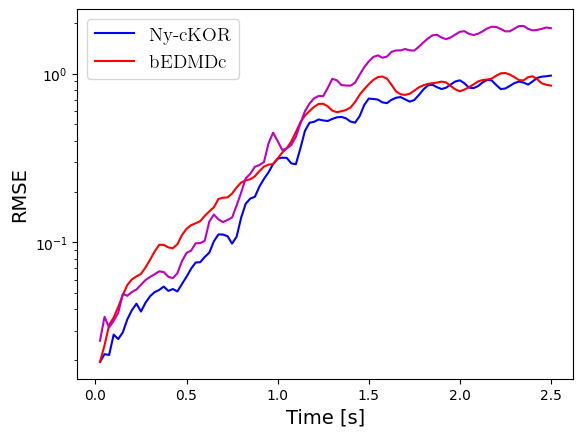

In [17]:
opt_penalty_KDMD=penalty_array[int(idx_penalty_KDMD)]
opt_mu_KDMD=mu_array[int(idx_mu_KDMD)]

opt_penalty_EDMD=opt_penalty_KDMD
opt_mu_EDMD=opt_mu_KDMD


opt_penalty_KDMD_r=opt_penalty_KDMD
opt_mu_KDMD_r=opt_mu_KDMD

#opt_penalty_KDMD=1e-8
#opt_mu_KDMD=100

X0_test=torch.unsqueeze(Trajtot_test[:,0,1],1)
Xtot_test=Trajtot_test[:,:,1]
Trajtot_U_test_1=torch.unsqueeze(Trajtot_U_test[:,:,1],2)
Ntraj_test1=1

RMSE_KDMD_test2, RMSE_over_time,X_pred_test,A_opt, B_opt, C_opt, Xtilde,t_regr_dur_opt,t_rollout_dur_opt=create_optimized_Ny_model_and_evaluate_over_test_data(opt_penalty_KDMD,opt_mu_KDMD,X_train,Y_train,U_train,Xtilde,Ytilde,Utilde,X0_test,Xtot_test,Trajtot_U_test_1,Nx,Nstep_test,Ntraj_test1,X_for_C_KDMD)
                                                                                                                                                        
RMSE_EDMD_test2, RMSE_over_time_EDMD,X_pred_test_EDMD,A_opt_EDMD, B_opt_EDMD, C_opt_EDMD,t_regr_dur_opt_EDMD,t_rollout_dur_opt_EDMD=create_optimized_model_and_evaluate_over_test_data(opt_penalty_EDMD,opt_mu_EDMD,'EDMD',X_centres,X_train,Y_train,U_train,N_D,X0_test,Xtot_test,Trajtot_U_test_1,Nx,Nstep_test,Ntraj_test1,X_for_C_EDMD)


r_mode_saved=False
reduced_rank_saved=reduced_rank
threshold_saved=threshold #Threshold for truncation, is not used if r_mode is True
RMSE_KDMD_test2_r, RMSE_over_time_r,X_pred_test_r,A_opt_r, B_opt_r, C_opt_r, Xtilde,Vh_r, r,t_regr_dur_opt_r,t_rollout_dur_opt_r=create_optimized_Ny_model_and_evaluate_over_test_data_rSVD(opt_penalty_KDMD_r,opt_mu_KDMD_r,X_train,Y_train,U_train,Xtilde,Ytilde,Utilde,X0_test,Xtot_test,Trajtot_U_test_1,Nx,Nstep_test,Ntraj_test1,r_mode_saved,threshold_saved,reduced_rank_saved,X_for_C_KDMD)

print('Regression time EDMD:',t_regr_dur_opt_EDMD)
print('Regression time KDMD:',t_regr_dur_opt)
print('Regression time rKDMD:',t_regr_dur_opt_r)

print('Rollout time EDMD:',t_rollout_dur_opt_EDMD)
print('Rollout time KDMD:',t_rollout_dur_opt)
print('Rollout time rKDMD:',t_rollout_dur_opt_r)

print('Total time EDMD:',t_regr_dur_opt_EDMD+t_rollout_dur_opt_EDMD)
print('Total time KDMD:',t_regr_dur_opt+t_rollout_dur_opt)
print('Total time rKDMD:',t_regr_dur_opt_r+t_rollout_dur_opt_r)

print('Optimal penalty EDMD:', opt_penalty_EDMD)
print('Optimal penalty KDMD:', opt_penalty_KDMD)
print('Optimal penalty rKDMD:', opt_penalty_KDMD_r)

print('Optimal mu EDMD:', opt_mu_EDMD)
print('Optimal mu KDMD:', opt_mu_KDMD)
print('Optimal mu rKDMD:', opt_mu_KDMD_r)

print('Validation error EDMD:',RMSE_EDMD_valid)
print('Validation error KDMD:',RMSE_KDMD_valid)
print('Validation error rKDMD:',RMSE_KDMD_r_valid)


print('Test error EDMD:',RMSE_EDMD_test2)
print('Test error KDMD:',RMSE_KDMD_test2)
print('Test error rKDMD:',RMSE_KDMD_test2_r)
print('Reduced lifted state dimension',r)



idx_end_time0=Nstep_valid
line_Ny_KDMD,=plt.plot(time_ma[:idx_end_time0],RMSE_over_time[:idx_end_time0], linestyle='-', color='b')
line_Ny_EDMD,=plt.plot(time_ma[:idx_end_time0],RMSE_over_time_EDMD[:idx_end_time0], linestyle='-', color='r')
line_Ny_KDMD_r,=plt.plot(time_ma[:idx_end_time0],RMSE_over_time_r[:idx_end_time0], linestyle='-', color='m')


#plt.ylim([1e-2,10])
plt.yscale("log") 
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.xlabel(r'Time [s]',fontsize=font_int)
plt.ylabel(r'RMSE',fontsize=font_int)
#plt.legend([line_Ny_KDMD,line_Ny_EDMD,line_Ny_KDMD_r], [r'Ny-bKDMDc',r'bEDMDc',r'Ny-bKDMDc-r'],fontsize=font_int)
plt.legend([line_Ny_KDMD,line_Ny_EDMD], [r'Ny-cKOR',r'bEDMDc'],fontsize=font_int)
#base_filename='Fluid_RMSE_over_time_no_vis'
#full_path=os.path.join(dir_name, base_filename + '.' + filename_suffix)
#plt.savefig(full_path, format=filename_suffix)

plt.show()



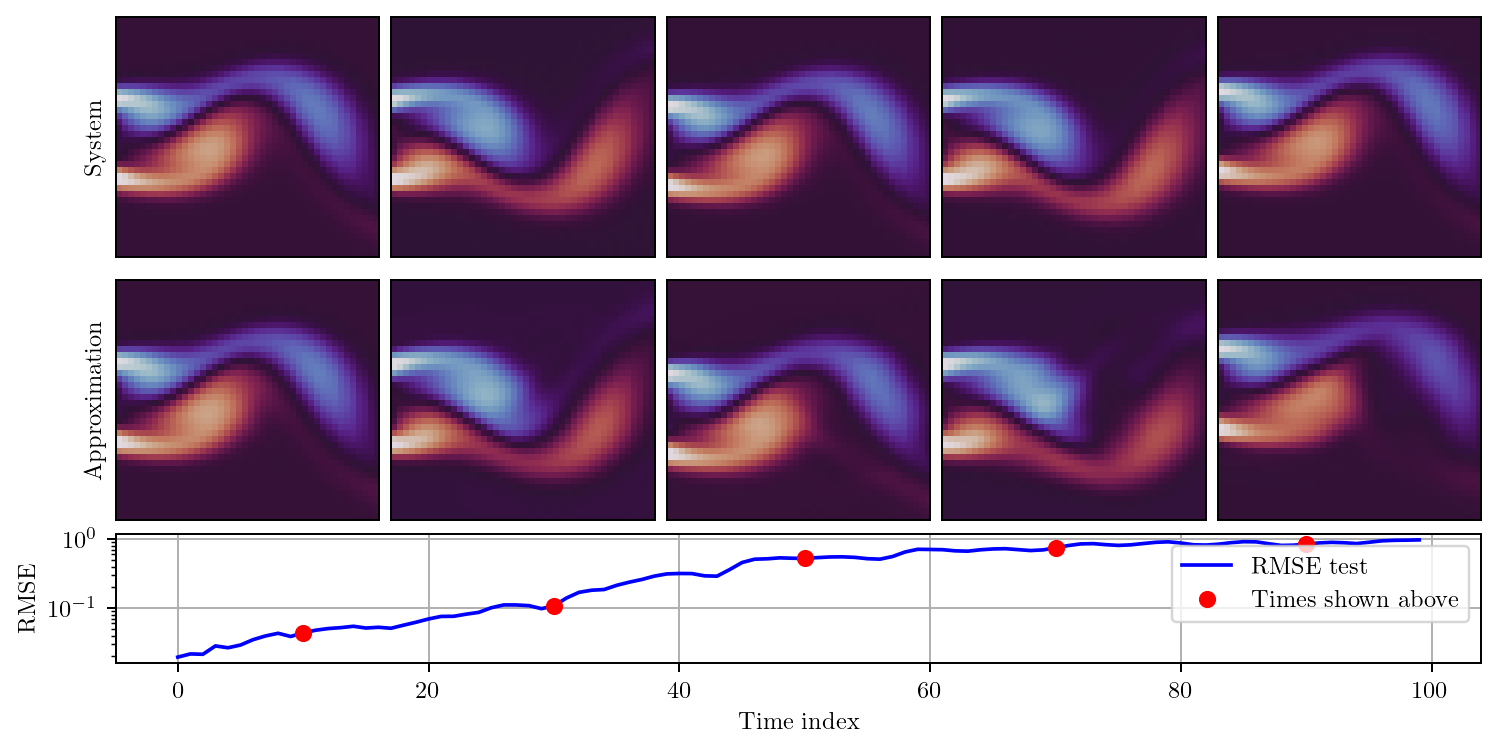

In [18]:
from matplotlib.gridspec import GridSpec
#import deepSI


def strip_plotter(Xtot_test_numpy_shaped, X_pred_test_numpy_shaped,ERROR_over_time,RMSE_mode,norm, to_img=None, plot_image=None, semi_log_y = False, n_plots=5, off_set=0, \
                  f_s=None, filename='UD-comparison-figure', cmap=None):
    DT = f_s == None
    f_s = 1 if f_s == None else f_s

    if RMSE_mode:
        NRMS_time = np.mean(np.mean((Xtot_test_numpy_shaped - X_pred_test_numpy_shaped)**2,axis=(2,3))**0.5/norm.ystd[:,0,0],axis=1)
        RMSE_over_time=NRMS_time
    else:
        RMSE_over_time=ERROR_over_time

    def plot(ax, image):
#         image = np.transpose(np.clip(np.round(image),0,255).astype(np.uint8),(1,2,0))
        if plot_image:
            plot_image(ax, image)
        else:
            img = to_img(image)
            ax.imshow(img,cmap=cmap)
        ax.tick_params(axis='x', labelbottom=False, bottom=False)
        ax.tick_params(axis='y', labelleft=False, left=False) 

    scale_factor = 1.7
    fig = plt.figure(figsize=(scale_factor*4.96063, scale_factor*2.5),dpi=300/scale_factor)
    
    gs = GridSpec(3, n_plots, height_ratios=[1,1,0.5])
#     fig = plt.figure(figsize=(width_target/my_dpi,height_target/my_dpi),dpi=my_dpi)

    
    A = np.linspace(0,len(RMSE_over_time), n_plots+1)
    time_ids = ((A[1:] + A[:-1])/2).astype(int) + off_set
    for time_id, col_id in zip(time_ids,range(n_plots)):
        ax = fig.add_subplot(gs[0,col_id]) #plt.subplot2grid((3, n_plots), (0, col_id)) #real
        plot(ax, Xtot_test_numpy_shaped[time_id])
        if col_id==0:
            ax.set_ylabel('System')
        ax = fig.add_subplot(gs[1,col_id])# plt.subplot2grid((3, n_plots), (1, col_id)) #pred
        plot(ax, X_pred_test_numpy_shaped[time_id])
        if col_id==0:
            ax.set_ylabel('Approximation')

    ax = fig.add_subplot(gs[2,:])#plt.subplot2grid((3,n_plots),(2,0), colspan=n_plots )
    ax.plot(np.arange(0,len(RMSE_over_time))/f_s,RMSE_over_time,'b')
    
    ax.semilogy()
    #ax.set_xlim(0,len(RMSE_over_time)/f_s)
    ax.grid()
    ax.plot(time_ids/f_s, RMSE_over_time[time_ids],'or')
    ax.set_xlabel('Time (seconds)' if not DT else 'Time index')
    ax.set_ylabel('RMSE')
    ax.legend(['RMSE test','Times shown above'], loc='upper right')
    plt.tight_layout(pad=0.5)
    #plt.savefig(filename)
    plt.show()

def vorticity(yi):
    u = yi[0]
    v = yi[1]
    wu = (u[1:,:-1]+u[1:,1:]) - (u[:-1,:-1]+u[:-1,1:])
    wv = -((v[:-1,1:]+v[1:,1:]) - (v[:-1,:-1]+v[1:,:-1]))
    return wu + wv


_, _ , VP_shaped, _= loadfile(matfiles[test_ids[0]])
X_pred_test_T=X_pred_test_r.T.numpy()

X_pred_test_numpy_shaped= X_pred_test_T.reshape(-1, 3, 45, 41)
X_pred_test_numpy_shaped= np.swapaxes(X_pred_test_numpy_shaped, 2, 3) #swap x and y for easier plotting


def loadfile2(name):
    c = scipy.io.loadmat(name)
    VP = c['VP']
    cylPos = c['cylPos'][0]
    time = c['time'][0]
    VPshaped = VP.reshape(-1, 3, 45, 41)
    VPshaped = np.swapaxes(VPshaped, 2, 3) #swap x and y for easier plotting
    return deepSI.System_data(u=cylPos, y=VPshaped)


#full_data = deepSI.System_data_list([loadfile2(name) for name in matfiles])
#norm = deepSI.system_data.System_data_norm()
#norm.ystd = np.std(full_data.y, axis=(0,2,3))[:,None,None]
norm=0
RMSE_mode=False #True means uses NRMSE error of Gerben script and False means uses own RMSE
idx_end_time=Nstep_valid
strip_plotter(VP_shaped[:idx_end_time,:,:,:], state_norm*X_pred_test_numpy_shaped[:idx_end_time,:,:,:],RMSE_over_time[:idx_end_time],RMSE_mode,norm, to_img=vorticity, n_plots=5, semi_log_y=True,\
              filename='Figs_Control_exp/test-strip-cylinder-flow.jpg' , cmap=plt.get_cmap('twilight'))
# %load_ext autoreload
# %autoreload 2

# from ..plot_scripts import make_video, strip_plotter

<Figure size 1488.19x750 with 0 Axes>

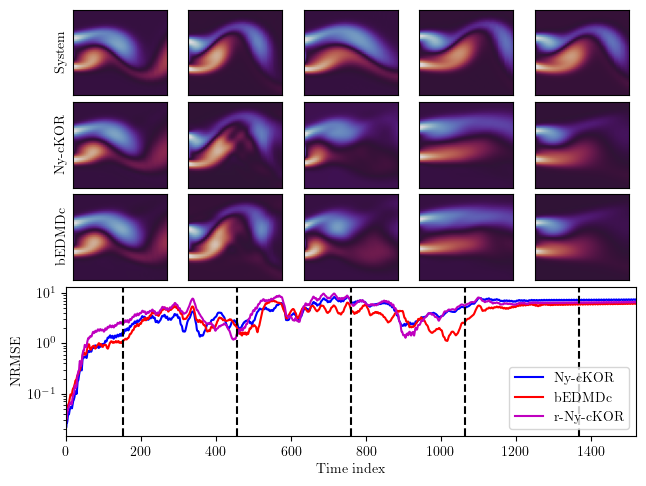

In [20]:



def strip_plotter(Xtot_test_numpy_shaped, X_pred_test_numpy_shaped,X_pred_test_numpy_shaped_EDMD,X_pred_test_numpy_shaped_r,ERROR_over_time,
                  ERROR_over_time_EDMD,ERROR_over_time_r,RMSE_mode,norm, to_img=None, plot_image=None, semi_log_y = False, n_plots=5, off_set=0, \
                  f_s=None, filename='UD-comparison-figure', cmap=None):
    DT = f_s == None
    f_s = 1 if f_s == None else f_s

    if RMSE_mode:
        NRMS_time = np.mean(np.mean((Xtot_test_numpy_shaped - X_pred_test_numpy_shaped)**2,axis=(2,3))**0.5/norm.ystd[:,0,0],axis=1)
        RMSE_over_time=NRMS_time

        NRMS_time_EDMD = np.mean(np.mean((Xtot_test_numpy_shaped - X_pred_test_numpy_shaped_EDMD)**2,axis=(2,3))**0.5/norm.ystd[:,0,0],axis=1)
        RMSE_over_time_EDMD=NRMS_time_EDMD

        NRMS_time_r = np.mean(np.mean((Xtot_test_numpy_shaped - X_pred_test_numpy_shaped_r)**2,axis=(2,3))**0.5/norm.ystd[:,0,0],axis=1)
        RMSE_over_time_r=NRMS_time_r
    else:
        RMSE_over_time=ERROR_over_time
        RMSE_over_time_EDMD=ERROR_over_time_EDMD
        RMSE_over_time_r=ERROR_over_time_r

    def plot(ax, image):
#         image = np.transpose(np.clip(np.round(image),0,255).astype(np.uint8),(1,2,0))
        if plot_image:
            plot_image(ax, image)
        else:
            img = to_img(image)
            ax.imshow(img,cmap=cmap)
        ax.tick_params(axis='x', labelbottom=False, bottom=False)
        ax.tick_params(axis='y', labelleft=False, left=False) 

    scale_factor = 3.4
    fig = plt.figure(figsize=(scale_factor*4.96063, scale_factor*2.5),dpi=300/scale_factor)
    fig = plt.figure()
    gs = GridSpec(4, n_plots, height_ratios=[1,1,1,1.75])
    #fig = plt.figure(figsize=(width_target/my_dpi,height_target/my_dpi),dpi=my_dpi)

    
    A = np.linspace(0,len(RMSE_over_time), n_plots+1)
    time_ids = ((A[1:] + A[:-1])/2).astype(int) + off_set

  
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')


    for time_id, col_id in zip(time_ids,range(n_plots)):
        ax = fig.add_subplot(gs[0,col_id]) #plt.subplot2grid((3, n_plots), (0, col_id)) #real
        plot(ax, Xtot_test_numpy_shaped[time_id])
        if col_id==0:
            ax.set_ylabel(r'System')
        ax = fig.add_subplot(gs[1,col_id])# plt.subplot2grid((3, n_plots), (1, col_id)) #pred
        plot(ax, X_pred_test_numpy_shaped[time_id])
        if col_id==0:
            ax.set_ylabel(r'Ny-cKOR')

        ax = fig.add_subplot(gs[2,col_id])
        plot(ax, X_pred_test_numpy_shaped_EDMD[time_id])
        if col_id==0:
            ax.set_ylabel(r'bEDMDc')


    ax = fig.add_subplot(gs[3,:])#plt.subplot2grid((3,n_plots),(2,0), colspan=n_plots )
    ax.plot(np.arange(0,len(RMSE_over_time))/f_s,RMSE_over_time,'b')
    ax.plot(np.arange(0,len(RMSE_over_time))/f_s,RMSE_over_time_EDMD,'r')
    ax.plot(np.arange(0,len(RMSE_over_time))/f_s,RMSE_over_time_r,'m')
    ax.semilogy()
    ax.set_xlim(0,(len(RMSE_over_time)-1)/f_s)
    #ax.grid()
    #ax.plot(time_ids/f_s, RMSE_over_time[time_ids],'xk')
    for i in range(n_plots):
        ax.axvline(time_ids[i]/f_s,0,1,color='k',linestyle='--')
    ax.set_xlabel(r'Time (seconds)' if not DT else r'Time index')
    ax.set_ylabel(r'NRMSE')
    ax.legend([r'Ny-cKOR',r'bEDMDc',r'r-Ny-cKOR'])
    plt.tight_layout(pad=0.5)
    #base_filename='Fluid_RMSE_over_time_vis_test1'
    #full_path=os.path.join(dir_name, base_filename + '.' + filename_suffix)
    #plt.savefig(full_path, format=filename_suffix)
    plt.show()

def vorticity(yi):
    u = yi[0]
    v = yi[1]
    wu = (u[1:,:-1]+u[1:,1:]) - (u[:-1,:-1]+u[:-1,1:])
    wv = -((v[:-1,1:]+v[1:,1:]) - (v[:-1,:-1]+v[1:,:-1]))
    return wu + wv


_, _ , VP_shaped, _= loadfile(matfiles[test_ids[0]])
X_pred_test_T=X_pred_test.T.numpy()

X_pred_test_numpy_shaped= X_pred_test_T.reshape(-1, 3, 45, 41)
X_pred_test_numpy_shaped= np.swapaxes(X_pred_test_numpy_shaped, 2, 3) #swap x and y for easier plotting

X_pred_test_T_EDMD=X_pred_test_EDMD.T.numpy()

X_pred_test_numpy_shaped_EDMD= X_pred_test_T_EDMD.reshape(-1, 3, 45, 41)
X_pred_test_numpy_shaped_EDMD= np.swapaxes(X_pred_test_numpy_shaped_EDMD, 2, 3) #swap x and y for easier plotting

X_pred_test_T_r=X_pred_test_r.T.numpy()

X_pred_test_numpy_shaped_r= X_pred_test_T_r.reshape(-1, 3, 45, 41)
X_pred_test_numpy_shaped_r= np.swapaxes(X_pred_test_numpy_shaped_r, 2, 3) #swap x and y for easier plotting


def loadfile2(name):
    c = scipy.io.loadmat(name)
    VP = c['VP']
    cylPos = c['cylPos'][0]
    time = c['time'][0]
    VPshaped = VP.reshape(-1, 3, 45, 41)
    VPshaped = np.swapaxes(VPshaped, 2, 3) #swap x and y for easier plotting
    return deepSI.System_data(u=cylPos, y=VPshaped)

RMSE_mode=False #True means uses NRMSE error of Gerben script and False means uses own RMSE
idx_end_time=None
strip_plotter(VP_shaped[:idx_end_time,:,:,:], state_norm*X_pred_test_numpy_shaped[:idx_end_time,:,:,:],state_norm*X_pred_test_numpy_shaped_EDMD[:idx_end_time,:,:,:],state_norm*X_pred_test_numpy_shaped_r[:idx_end_time,:,:,:],
              RMSE_over_time[:idx_end_time],RMSE_over_time_EDMD[:idx_end_time],RMSE_over_time_r[:idx_end_time],RMSE_mode,norm, to_img=vorticity, n_plots=5, semi_log_y=True,\
              filename='Figs_Control_exp/test-strip-cylinder-flow.jpg' , cmap=plt.get_cmap('twilight'))
# %load_ext autoreload
# %autoreload 2

# from ..plot_scripts import make_video, strip_plotter